In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

In [3]:
# =============================== PREVIOUS CODE ===============================
vocab = "$" + ''.join(chr(ord('a') + i) for i in range(26))
vocab_size = len(vocab)
# Create dictionaries for character to index and index to character
ch_to_i = {char: i for i, char in enumerate(vocab)}
i_to_ch = {i: char for i, char in enumerate(vocab)}

# Define encode and decode functions
encode = lambda word: torch.tensor([ch_to_i[c] for c in word])
decode = lambda tensor_i: ''.join(i_to_ch[i.item()] for i in tensor_i)

# Get data
names = []
with open('../data/p2ch9/names_2022.txt', 'r') as file:
    for line in file:
        name, _, _= line.lower().strip().split(',')
        names.append(name)

# filter out names 10 characters and longer
names = [name for name in names if len(name) < 10]
# Add special character boundary to names
names = ['$' + name + '$' for name in names]

# Length of max name
max_name_length = max(len(name) for name in names)
longest_name = max(names, key=len)
longest_name_index = names.index(longest_name)

# Create a function to get a batch of data
names_index = [torch.tensor([ch_to_i[char] for char in name]) for name in names]
targets_index = [name_index[1:] for name_index in names_index]
names_index[0], targets_index[0]

from torch.nn.utils.rnn import pad_sequence
X = pad_sequence(names_index, batch_first=True, padding_value=0)
# trick to pad Y with with -1 and the same size as X
targets_index.append(X[0])
Y = pad_sequence(targets_index, batch_first=True, padding_value=-1)[:-1]

def get_batch(batch_size=64):
    random_idx = torch.randint(0, X.size(0), (batch_size,))
    batch = X[random_idx]
    labels = Y[random_idx]
    return batch, labels
batch, labels = get_batch()

def train(model, optimizer, num_steps=10_001, loss_report_interval=1_000):
    losses = []
    for i in range(1, num_steps):
        inputs, labels = get_batch()
        optimizer.zero_grad()
        logits = model(inputs)
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), labels.view(-1), ignore_index=-1)
        losses.append(loss.item())
        if i % loss_report_interval == 0:
            print(f'Average loss at step {i}: {sum(losses[-loss_report_interval:]) / loss_report_interval:.4f}')
        loss.backward()
        optimizer.step()

def generate_samples(model, num_samples=1, max_len=max_name_length):
    sequences = torch.zeros((num_samples, 1)).int()
    for _ in range(max_len):
        logits = model(sequences)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        sequences = torch.cat((sequences, idx_next), dim=1)

    for sequence in sequences:
        indices = torch.where(sequence == 0)[0]
        end = indices[1] if len(indices) > 1 else max_len
        sequence = sequence[1:end]
        print(decode(sequence))
# =============================== FINISH PREVIOUS CODE ===============================

In [4]:
torch.manual_seed(0)
x = torch.rand(4, 3)

query = F.linear(x, weight=torch.rand(3, 3), bias=torch.rand(3)) #  <1>
key = F.linear(x, weight=torch.rand(3, 3), bias=torch.rand(3))
value = F.linear(x, weight=torch.rand(3, 3), bias=torch.rand(3))

def dot_product_attention_single(q, k, v):
    attn_weights = q @ k.T #  <2>
    attn_weights = F.softmax(attn_weights, dim=-1) #  <3>
    output = attn_weights @ v #  <4>
    return output

dot_product_attention_single(query, key, value)

tensor([[1.2696, 1.6192, 1.1415],
        [1.2808, 1.6278, 1.1436],
        [1.2938, 1.6351, 1.1450],
        [1.2768, 1.6246, 1.1428]])

In [5]:
torch.manual_seed(0)
x = torch.rand(1, 4, 3) # <1>

query = F.linear(x, weight=torch.rand(3, 3), bias=torch.rand(3))
key = F.linear(x, weight=torch.rand(3, 3), bias=torch.rand(3))
value = F.linear(x, weight=torch.rand(3, 3), bias=torch.rand(3))

def scaled_dot_product_causal_attention(q, k, v):
    # assumes batch dimension is present
    attn_weights = q @ k.transpose(1, 2) # <2>
    # create a mask to prevent the model from attending to future tokens
    mask = torch.tril(torch.ones(attn_weights.shape[1:]), diagonal=0) # <3>
    attn_weights = attn_weights.masked_fill(mask == 0, value=float('-inf'))
    # normalize the attention weights
    attn_weights = attn_weights / torch.sqrt(torch.tensor(k.shape[-1]).float()) # <4>
    attn_weights = F.softmax(attn_weights, dim=-1)
    output = attn_weights @ v
    return output, attn_weights

output, attn_weights = scaled_dot_product_causal_attention(query, key, value)
print(output)

tensor([[[1.1238, 1.6097, 1.1210],
         [1.0748, 1.4402, 1.0530],
         [1.2922, 1.6018, 1.1130],
         [1.2236, 1.5888, 1.1344]]])


In [6]:
torch.manual_seed(0)
x = torch.rand(1, 4, 3)  # <1>

# Add an additional dimension for the heads
num_heads = 2
x = x.view(x.shape[0], num_heads, x.shape[1] // num_heads, -1)
print(x.shape)

query = F.linear(x, weight=torch.rand(3, 3), bias=torch.rand(3))
key = F.linear(x, weight=torch.rand(3, 3), bias=torch.rand(3))
value = F.linear(x, weight=torch.rand(3, 3), bias=torch.rand(3))

# Reshape back to 3D
query = query.view(x.shape)
key = key.view(x.shape)
value = value.view(x.shape)

def scaled_dot_product_causal_attention(q, k, v):
    # assumes batch dimension is present
    attn_weights = q @ k.transpose(-2, -1)  # <2>
    # create a mask to prevent the model from attending to future tokens
    mask = torch.tril(torch.ones(attn_weights.shape[-2:]), diagonal=0)  # <3>
    attn_weights = attn_weights.masked_fill(mask == 0, value=float('-inf'))
    # normalize the attention weights
    attn_weights = attn_weights / torch.sqrt(torch.tensor(k.shape[-1]).float())  # <4>
    attn_weights = F.softmax(attn_weights, dim=-1)
    output = attn_weights @ v
    return output, attn_weights

output, attn_weights = scaled_dot_product_causal_attention(query, key, value)
print(output)

expected_output = F.scaled_dot_product_attention(query, key, value, is_causal=True)
expected_output

torch.Size([1, 2, 2, 3])
tensor([[[[1.1238, 1.6097, 1.1210],
          [1.0748, 1.4402, 1.0530]],

         [[1.5072, 1.7621, 1.1726],
          [1.3289, 1.6948, 1.1924]]]])


tensor([[[[1.1238, 1.6097, 1.1210],
          [1.0748, 1.4402, 1.0530]],

         [[1.5072, 1.7621, 1.1726],
          [1.3289, 1.6948, 1.1924]]]])

In [7]:
expected_output = F.scaled_dot_product_attention(query, key, value, is_causal=True)
print(torch.allclose(output, expected_output))

True


In [8]:
class AttentionMLP(nn.Module):
    def __init__(self, n_embd, vocab_size, block_size, n_hidden=64):
        super().__init__()
        self.tok_embd = nn.Embedding(vocab_size, n_embd)
        self.attn_weights = None

        self.query_proj = nn.Linear(n_embd, n_embd)
        self.key_proj = nn.Linear(n_embd, n_embd)
        self.value_proj = nn.Linear(n_embd, n_embd)

        self.register_buffer("mask", torch.tril(torch.ones((block_size, block_size)), diagonal=0))

        self.mlp = nn.Sequential(
            nn.Linear(n_embd, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_embd)
        )

        self.output_proj = nn.Linear(n_embd, vocab_size)
    
    def forward(self, x):
        x = self.tok_embd(x)
        batch_size, seq_len, embd_dim = x.shape

        q = self.query_proj(x)
        k = self.key_proj(x)
        v = self.value_proj(x)

        attn_weights = q @ k.transpose(1, 2)
        attn_weights = attn_weights.masked_fill(self.mask[:seq_len, :seq_len] == 0, value=float('-inf'))
        attn_weights = attn_weights / torch.sqrt(torch.tensor(k.shape[-1]).float())
        self.attn_weights = F.softmax(attn_weights, dim=-1)
        x = self.attn_weights @ v
        x = self.mlp(x)
        
        x = self.output_proj(x)
        return x

model = AttentionMLP(32, vocab_size, max_name_length)
optimizer = optim.SGD(model.parameters(), lr=0.01)
train(model, optimizer, num_steps=10_001, loss_report_interval=1_000)

Average loss at step 1000: 2.9573
Average loss at step 2000: 2.7007
Average loss at step 3000: 2.6209
Average loss at step 4000: 2.5798
Average loss at step 5000: 2.5464
Average loss at step 6000: 2.5015
Average loss at step 7000: 2.4669
Average loss at step 8000: 2.4433
Average loss at step 9000: 2.4240
Average loss at step 10000: 2.4125


In [10]:
generate_samples(model, 10)

tege
ondad
anzioin
gazeeh
axklynis
yuan
hansy
onos
nreey
eldole


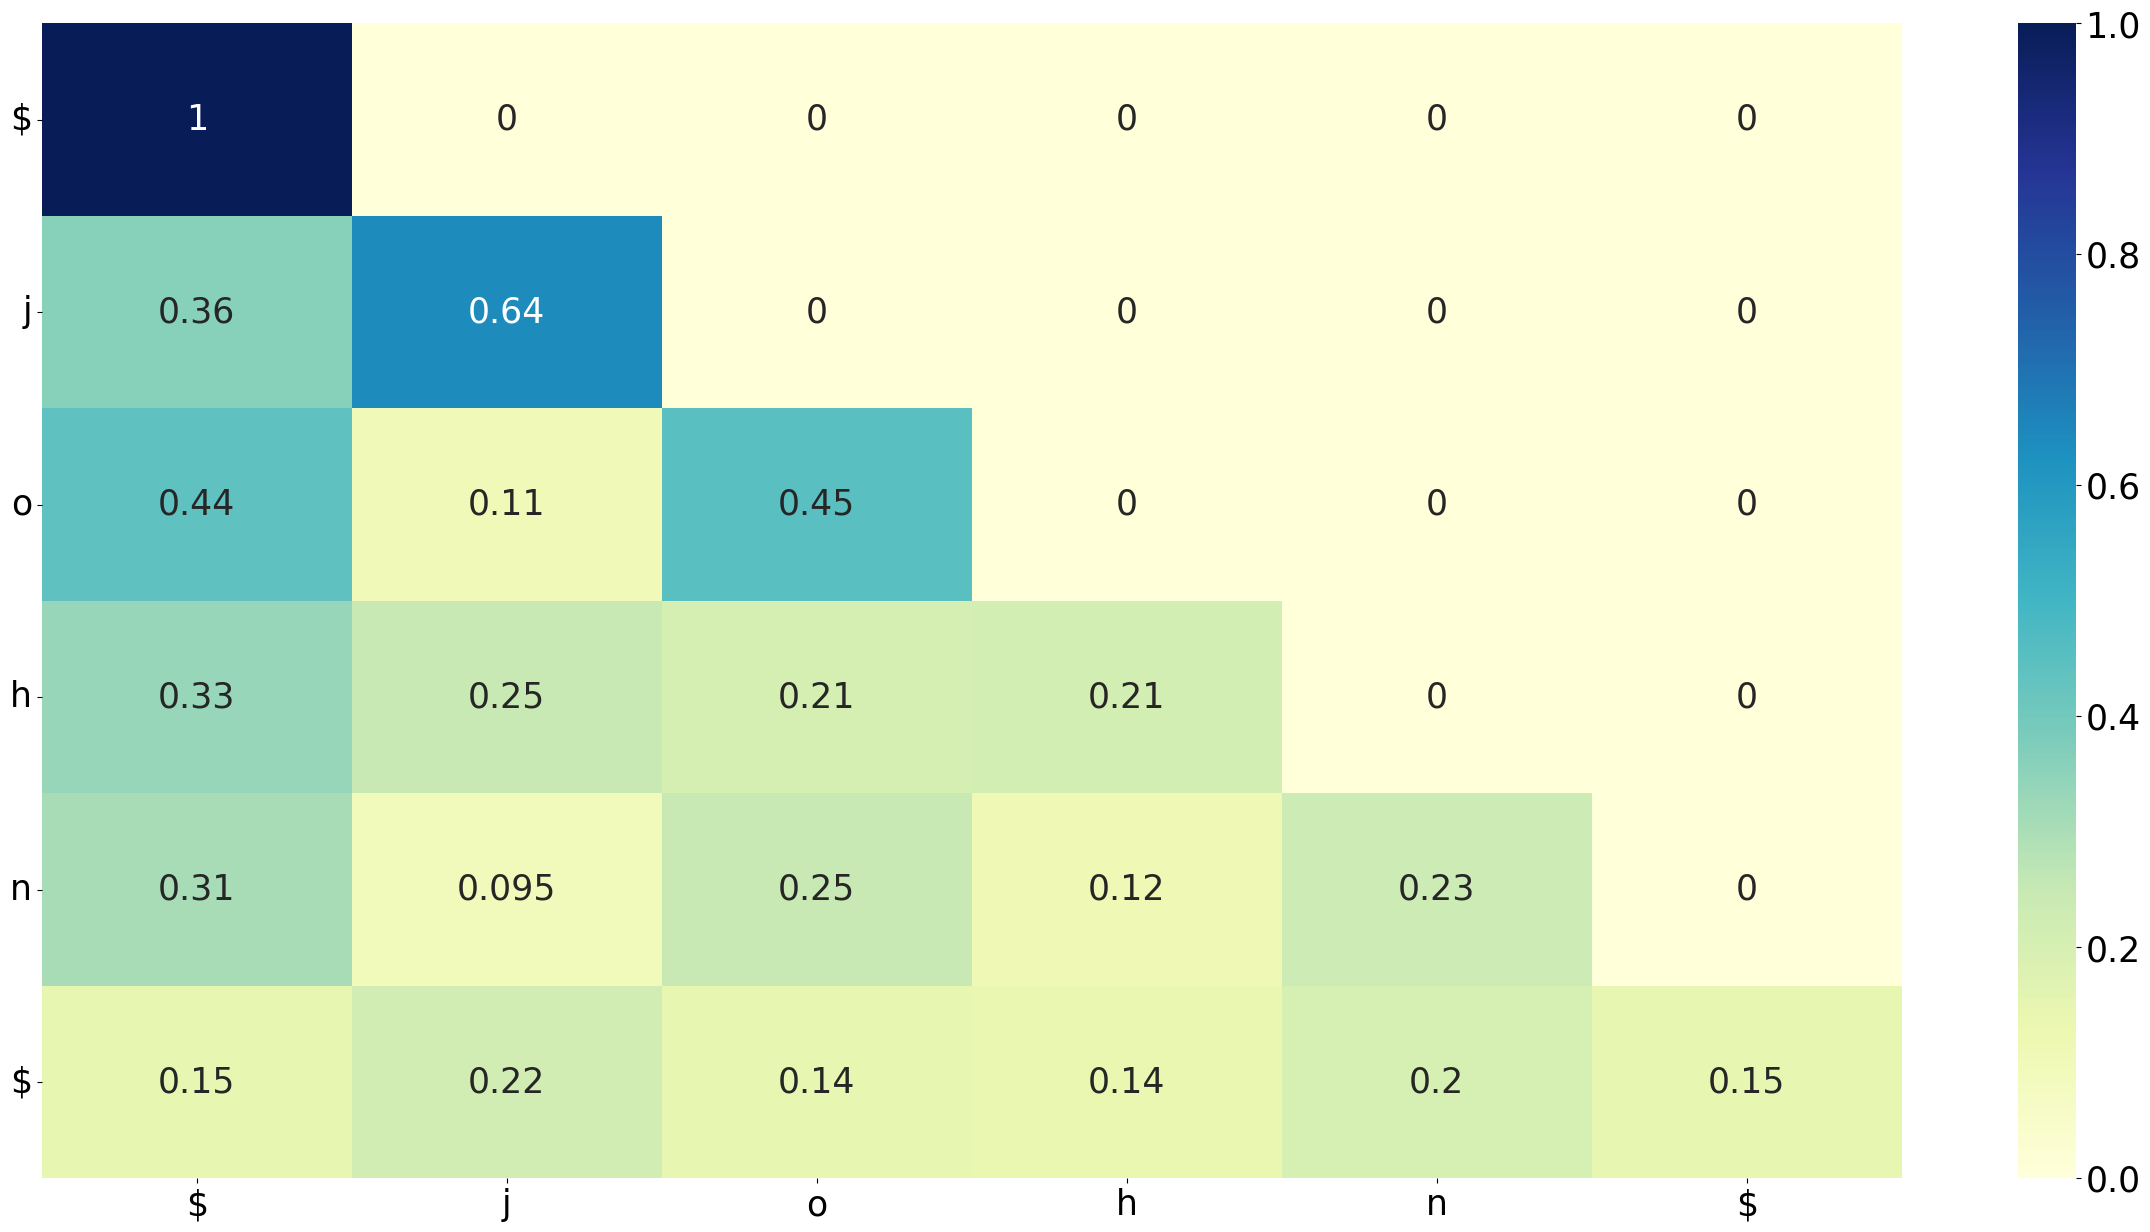

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(attention_weights, name):
    plt.figure(figsize=(30, 15))
    ax = sns.heatmap(attention_weights.cpu().detach().numpy(), annot=True, cmap="YlGnBu", annot_kws={"size": 25})
    labels = list(name)
    ticks = [i + 0.5 for i in range(len(labels))]
    plt.xticks(ticks=ticks, labels=labels, rotation='horizontal')
    plt.yticks(ticks=ticks, labels=labels, rotation='horizontal')
    plt.tick_params(axis='both', which='major', labelsize=25)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=25)  # Set font size of the color bar's labels
    plt.show()

name = "$" + "john" + "$"
encoded_name = encode(name)
model(encoded_name.unsqueeze(0))
attn_weights = model.attn_weights[0]
visualize_attention(attn_weights, name)

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, num_heads=4, n_hidden=64):
        super().__init__()
        assert n_embd % num_heads == 0, "Embedding dimension must be divisible by the number of heads"

        self.num_heads = num_heads # <1>
        self.head_dim = n_embd // num_heads

        self.query_proj = nn.Linear(n_embd, n_embd)
        self.key_proj = nn.Linear(n_embd, n_embd)
        self.value_proj = nn.Linear(n_embd, n_embd)

        self.mlp = nn.Sequential(
            nn.Linear(n_embd, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_embd)
        )

        self.norm_1 = nn.LayerNorm(n_embd)
        self.norm_2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        batch_size, sequence_length, _ = x.shape

        q = self.query_proj(x)
        k = self.key_proj(x)
        v = self.value_proj(x)

        # multiheaded attention
        q = q.view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2) # <1>
        k = k.view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, sequence_length, self.num_heads, self.head_dim).transpose(1, 2)

        # attention
        attn_weights = F.scaled_dot_product_attention(q, k, v, is_causal=True)

        # multiple heads concatenation
        attn_weights = attn_weights.transpose(1, 2).contiguous().view(batch_size, sequence_length, -1)

        # norm and residual connections here
        x = self.norm_1(x + attn_weights)
        x = self.norm_2(x + self.mlp(x))
        return x

In [12]:
class Transformer(nn.Module):
    def __init__(self, n_embd, vocab_size, block_size, num_blocks=6):
        super().__init__()
        self.char_embedding = nn.Embedding(vocab_size, n_embd)
        self.positional_embedding = nn.Embedding(block_size, n_embd)

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(n_embd) for _ in range(num_blocks)]
        )

        self.output_proj = nn.Linear(n_embd, vocab_size)
    
    def forward(self, x):
        _, seq_len = x.shape

        pos_embd = self.positional_embedding(torch.arange(seq_len)) #  <1>
        char_embd = self.char_embedding(x)
        x = char_embd + pos_embd
        x = self.transformer_blocks(x)
        x = self.output_proj(x)

        return x
    
n_embd = 64
model = Transformer(n_embd, vocab_size, block_size=max_name_length)
optimizer = optim.SGD(model.parameters(), lr=0.1)
train(model, optimizer, num_steps=10_001, loss_report_interval=1_000)

Average loss at step 1000: 2.2924
Average loss at step 2000: 2.1520
Average loss at step 3000: 2.0999
Average loss at step 4000: 2.0626
Average loss at step 5000: 2.0346
Average loss at step 6000: 2.0107
Average loss at step 7000: 1.9852
Average loss at step 8000: 1.9629
Average loss at step 9000: 1.9477
Average loss at step 10000: 1.9299


In [22]:
train(model, optimizer, num_steps=4_001, loss_report_interval=1_000)

Average loss at step 1000: 1.9133
Average loss at step 2000: 1.8956
Average loss at step 3000: 1.8824
Average loss at step 4000: 1.8689


In [25]:
generate_samples(model, num_samples=10)

journe
green
huxson
chanie
antura
robinna
bryce
jazleah
daryza
bailanie
